# Figures: comparing definitions of memorization

In [1]:
import sys

sys.path.append("/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm")

## Setup

In [2]:
from grokking_llm.utils import (
    DeploymentCfg,
    get_pointwise_container,
)
from grokking_llm.measures_stat import(
    CounterfactualMemoStatic,
    MemoMembershipStatic,
)
from grokking_llm.training import (
    get_dataset,
    format_dataset,
    add_labels,
)

2024-09-19 13:25:30.687 | INFO     | grokking_llm.utils.logs:<module>:20 - Welcome to `grokking_llm` module!


2024-09-19 13:25:30.914 | INFO     | grokking_llm.utils.env_vars:<module>:15 - Found an environment var config at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/env_vars.cfg, exporting its variables.
2024-09-19 13:25:30.916 | DEBUG    | grokking_llm.utils.env_vars:<module>:34 - Exporting env var OMP_NUM_THREADS=2
2024-09-19 13:25:30.918 | DEBUG    | grokking_llm.utils.hf_hub:<module>:32 - Setting env variable HF_HOME=/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/.cache/huggingface
2024-09-19 13:25:30.919 | INFO     | grokking_llm.utils.hf_hub:<module>:37 - Config internet.offline = false
2024-09-19 13:25:30.919 | DEBUG    | grokking_llm.utils.hf_hub:<module>:49 - Looking for HF token at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/credentials.cfg ...
2024-09-19 13:25:30.921 | INFO     | grokking_llm.utils.hf_hub:<module>:54 - Found HF token hf_*****************************xTkqH
2024-09-19 13:25:30.922 | DEBUG    | grokking_ll

In [6]:
import collections
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr, rankdata

## Loading

In [4]:
setup_names = [
    "arc__mis",
    "ethi_mis",
    "mmlu_mis",
    "mmlu_lla",
    "mmlu_gem",
]
dep_cfg = {
    "arc__mis": DeploymentCfg.autoconfig("H5gQ"),
    "ethi_mis": DeploymentCfg.autoconfig("JNey"),
    "mmlu_mis": DeploymentCfg.autoconfig("Z5n7"),
    "mmlu_lla": DeploymentCfg.autoconfig("ZfTT"),
    "mmlu_gem": DeploymentCfg.autoconfig("mD9I"),
}
checkpoints = {
    "arc__mis": [50,100,150,200,250,1000,1750,2500],
    "ethi_mis": [397,794,1191,1588,1985,7940,13895,19850],
    "mmlu_mis": [750,1500,2250,3000,3750,15000,26250,37500],
    "mmlu_lla": [750,1500,2250,3000,3750,15000,26250,37500],
    "mmlu_gem": [750,1500,2250,3000,3750,15000,26250,37500],
}

2024-09-19 13:26:07.457 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: wd1y is the prefix of confi_id wd1yKu7ifTBhJncAHIe3vA in `paths.individual_outputs`, building from it.
2024-09-19 13:26:07.464 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-19 13:26:07.465 | WARNING  | grokking_llm.utils.training_cfg:__init__:735 - You selected `cuda` accelerator, but it is not available. CPU will be used instead.
2024-09-19 13:26:07.473 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: M-H- is the prefix of confi_id M-H-RqkPbMpWRGgOcg-PRA in `paths.individual_outputs`, building from it.
2024-09-19 13:26:07.477 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-19

In [7]:
checkpoint_to_epoch = collections.defaultdict(dict)
for setup in setup_names:
    for idx_chk, chk in enumerate(checkpoints[setup]):
        checkpoint_to_epoch[setup][chk] = {
            0: 0.2,
            1: 0.4,
            2: 0.6,
            3: 0.8,
            4: 1.0,
            5: 4.0,
            6: 7.0,
            7: 10.0,
        }[idx_chk]

In [9]:
global_idx = {}
for setup in setup_names:
    train_ds = get_dataset(dep_cfg[setup].base_config, split="train")
    train_ds = format_dataset(train_ds, dep_cfg[setup].base_config)
    train_ds = add_labels(train_ds, dep_cfg[setup].base_config, split="train")
    global_idx[setup] = train_ds["global_index"]

for setup in setup_names:
    print(f"[{setup}] {len(global_idx[setup])} elements")

2024-09-19 13:27:18.052 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-19 13:27:18.054 | INFO     | grokking_llm.training.datasets:format_dataset:174 - Formatting dataset ai2_arc
2024-09-19 13:27:18.055 | DEBUG    | grokking_llm.training.datasets:format_dataset:175 - Using seed=0 and force_template=False for formatting.
Map: 100%|██████████| 2000/2000 [00:00<00:00, 5296.42 examples/s]
2024-09-19 13:27:18.442 | INFO     | grokking_llm.training.datasets:add_labels:233 - Adding labels to dataset ai2_arc
2024-09-19 13:27:18.443 | DEBUG    | grokking_llm.training.datasets:add_labels:234 - Using proportion label_noise=0.03334 with seed=0
Map: 100%|██████████| 2000/2000 [00:00<00:00, 9404.37 examples/s] 
2024-09-19 13:27:21.144 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset hendrycks/ethics split train
2024-09-19 13:27:21.146 | INFO     | grokking_llm.training.datasets:format_dataset:174 - Formatting dat

[arc__mis] 2000 elements
[ethi_mis] 15880 elements
[mmlu_mis] 30000 elements
[mmlu_lla] 30000 elements
[mmlu_gem] 30000 elements


### Containers - memorization

In [10]:
def sanityze(memo_per_chk_per_idx):

    num_changed = 0

    for chk in memo_per_chk_per_idx:
        for idx in memo_per_chk_per_idx[chk]:
            old_val = memo_per_chk_per_idx[chk][idx]
            memo_per_chk_per_idx[chk][idx] = max(-100.0, memo_per_chk_per_idx[chk][idx])
            memo_per_chk_per_idx[chk][idx] = min(100.0, memo_per_chk_per_idx[chk][idx])
            
            if old_val != memo_per_chk_per_idx[chk][idx]:
                num_changed += 1

    print(f"Num item changed: {num_changed}")

In [13]:
counterfactual_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    memo = CounterfactualMemoStatic(dep_cfg[setup])
    memo_df = memo.load_metrics_df()
    counterfactual_per_setup_per_chk_per_idx[setup] = get_pointwise_container(memo_df, memo.column_offset)

2024-09-19 13:31:23.259 | INFO     | grokking_llm.measures_stat.static_metrics_group:__init__:61 - Creating a static metric object to measure `counterfactual_memorization_static` on config H5gQZhfMsLE5_NTX9hR7TA
2024-09-19 13:31:23.263 | INFO     | grokking_llm.measures_stat.static_metrics_group:__init__:72 - Loading full dataset to retrieve global_index.
2024-09-19 13:31:26.429 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-19 13:31:26.438 | DEBUG    | grokking_llm.measures_stat.static_metrics_group:__init__:82 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/deployment/H5gQZhfMsLE5_NTX9hR7TA/metrics/counterfactual_memorization_static.csv
2024-09-19 13:31:26.439 | INFO     | grokking_llm.measures_stat.static_metrics_group:__init__:85 - Fetching all possible TrainingCfg for this deployment config.
100%|██████████| 8/8 [00:00<00:00, 21.56it/s]
2024-09-19 13:31:26.882 | INFO     

In [14]:
lira_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    memo = MemoMembershipStatic(dep_cfg[setup])
    memo_df = memo.load_metrics_df()
    lira_per_setup_per_chk_per_idx[setup] = get_pointwise_container(memo_df, memo.column_offset)

2024-09-19 13:31:55.167 | INFO     | grokking_llm.measures_stat.static_metrics_group:__init__:61 - Creating a static metric object to measure `memo_mia_static` on config H5gQZhfMsLE5_NTX9hR7TA
2024-09-19 13:31:55.171 | INFO     | grokking_llm.measures_stat.static_metrics_group:__init__:72 - Loading full dataset to retrieve global_index.
2024-09-19 13:31:58.061 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-19 13:31:58.069 | DEBUG    | grokking_llm.measures_stat.static_metrics_group:__init__:82 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/deployment/H5gQZhfMsLE5_NTX9hR7TA/metrics/memo_mia_static.csv
2024-09-19 13:31:58.070 | INFO     | grokking_llm.measures_stat.static_metrics_group:__init__:85 - Fetching all possible TrainingCfg for this deployment config.
100%|██████████| 8/8 [00:00<00:00, 24.02it/s]
2024-09-19 13:31:58.475 | INFO     | grokking_llm.measures_stat.static_me

In [54]:
MEMO_CONTAINER_AND_REVERSED= {
    "Counterfactual Memo": counterfactual_per_setup_per_chk_per_idx,
    "Membership Inf (LiRA)": lira_per_setup_per_chk_per_idx,
}

In [55]:
PRETTY_SETUP = {
    "arc__mis": "ARC/Mistral",
    "ethi_mis": "ETHICS/Mistral",
    "mmlu_mis": "MMLU/Mistral",
    "mmlu_lla": "MMLU/Llama",
    "mmlu_gem": "MMLU/Gemma",
}

## Comparing: ETHICS

In [52]:
setup = "mmlu_lla"
checkpoint = checkpoints[setup][-1]

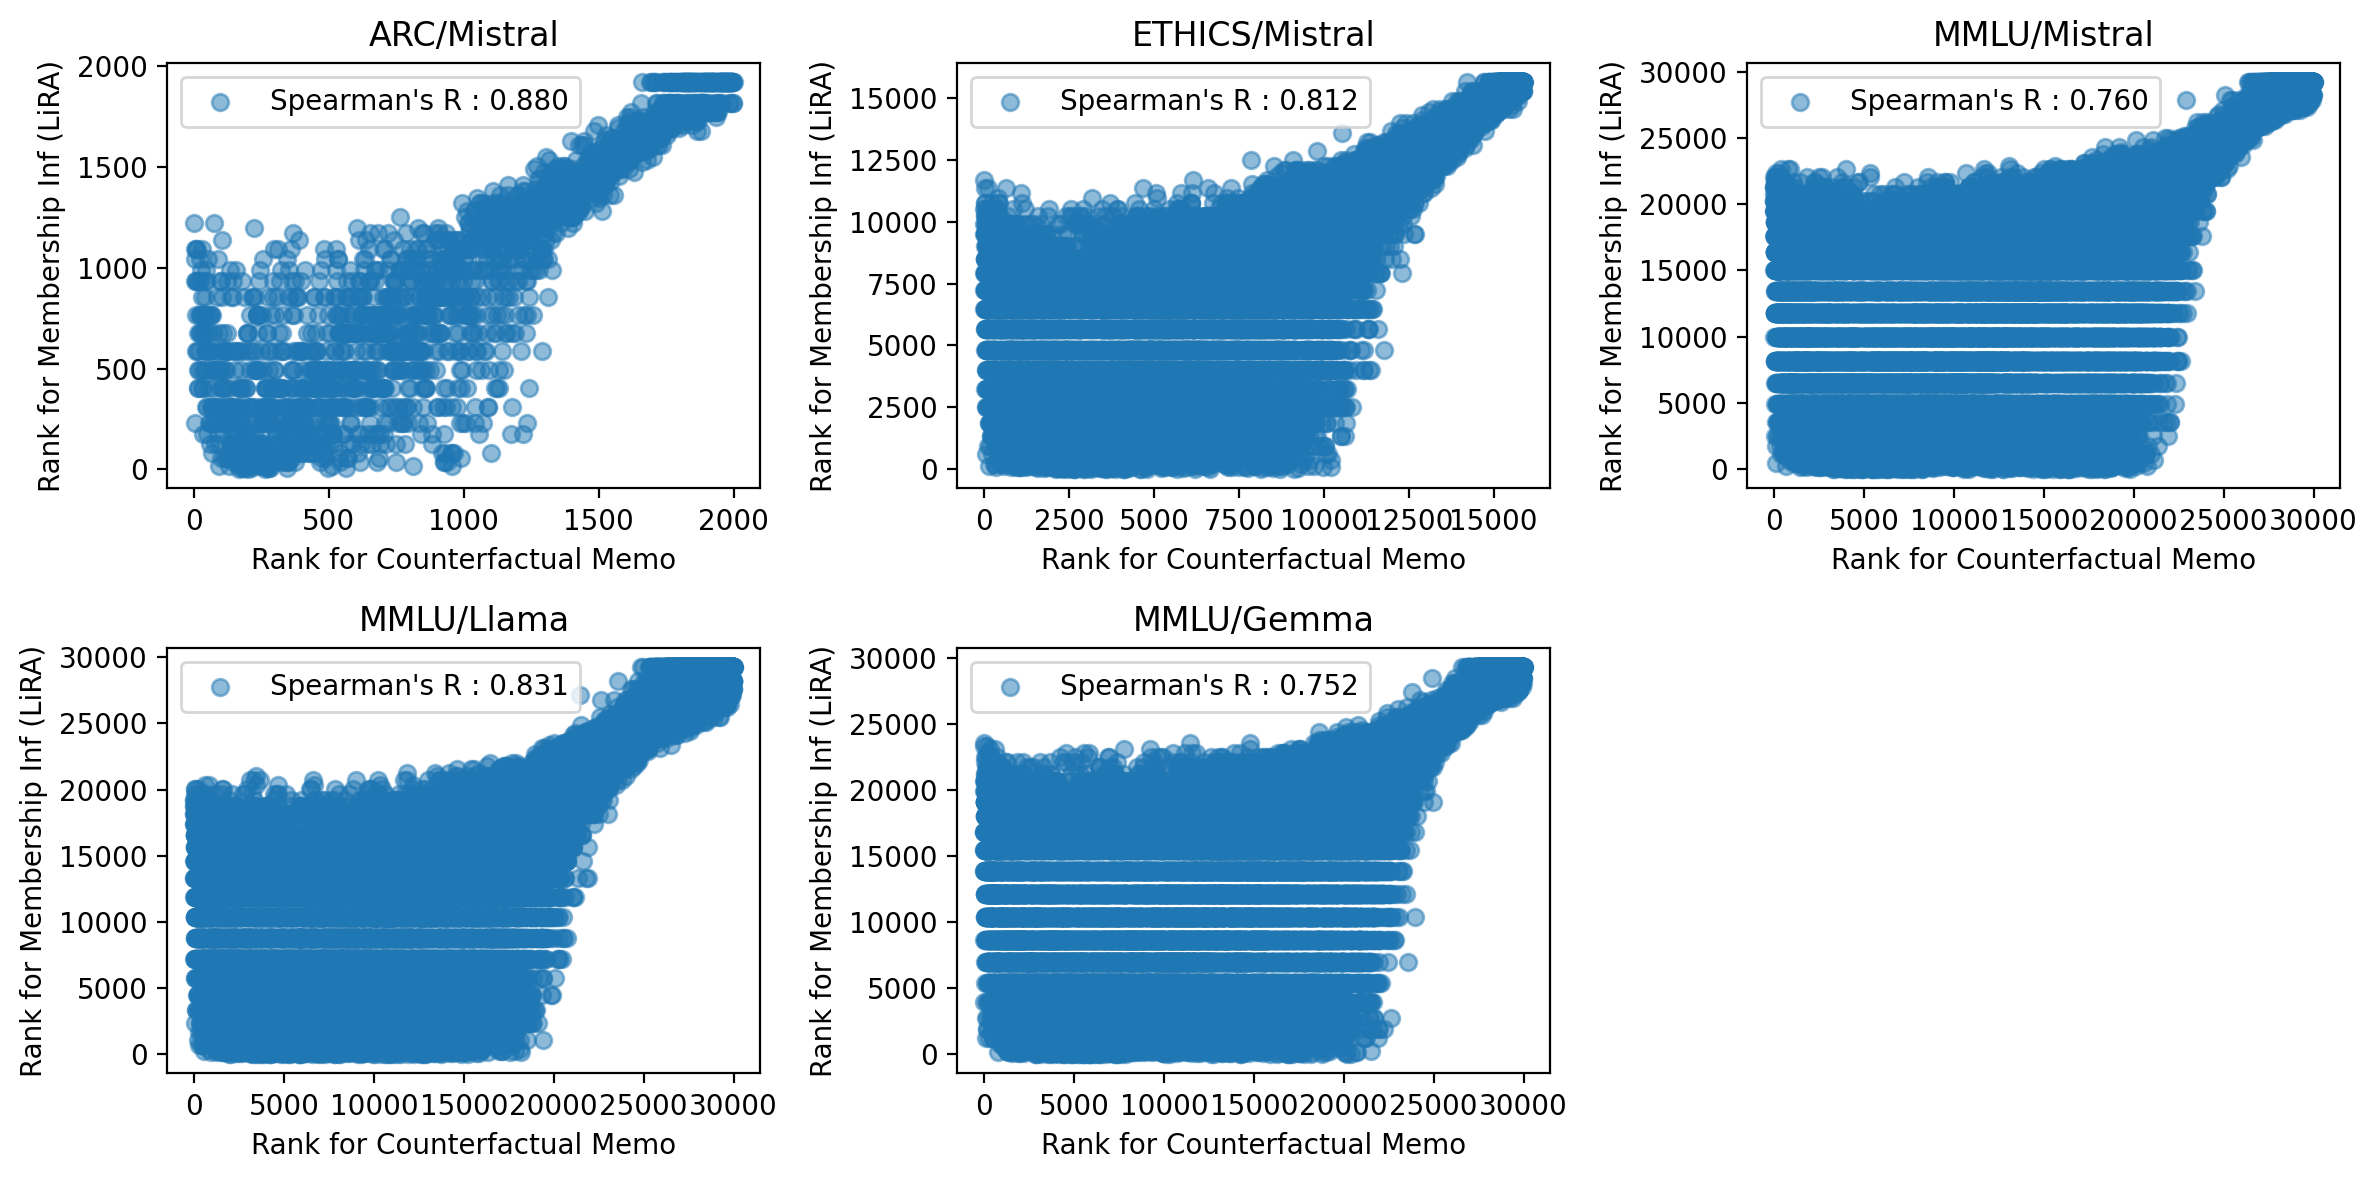

In [63]:
n_cols = 3
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), dpi=200)

idx_to_ax = {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1)}

for idx_setup, setup in enumerate(setup_names):
        
        # Ax
        ax = axs[idx_to_ax[idx_setup]]
        
        # Getting rank of each sample
        titles = []
        values = []
        for title, container in MEMO_CONTAINER_AND_REVERSED.items():
            titles.append(title)
            values.append(rankdata([container[setup][checkpoints[setup][-1]][idx] for idx in global_idx[setup]]))

        # Spearman's R
        r_tot = spearmanr(values[0], values[1]).statistic

        # Scatter
        ax.scatter(values[0], values[1], alpha=0.5, label=f"Spearman's R : {r_tot:.3f}")

        # Plot details
        ax.set_xlabel(f"Rank for {titles[0]}")
        ax.set_ylabel(f"Rank for {titles[1]}")
        ax.set_title(PRETTY_SETUP[setup])
        ax.legend()

axs[1, 2].axis("off")
fig.tight_layout()
fig.savefig("appendix_comparing_memorization.png")